# TP3: Técnicas de Machine Learning para clasificar datos de EEG

<p style="text-align: justify;">
En el marco de la materia optativa *Ciencia de Datos* estudiamos técnicas de Machine Learning aplicadas a datos adquiridos mediante electroencefalografía (EEG). En la [página web de la materia](http://www.dc.uba.ar/materias/cienciadatos) se encuentran disponibles los [datos](http://calamaro.exp.dc.uba.ar/~fraimondo/cienciadatos/data/) utilizados, así como también las [referencias teóricas](http://www.dc.uba.ar/materias/cienciadatos/teoricas) y la [guía](https://gist.github.com/fraimondo/9f779d083a47c18800130ca8d1b143b9) para el desarrollo de los análisis correspondientes. <br>

<p>
En el presente trabajo aplicamos técnicas de Machine Learning univariadas (una variable/feature) y multivariadas (mutiples variabes/features) para entrenar clasificadores supervisados que permitan discriminar grupos de datos de EEG a partir de ciertos atributos o *features*.
</p> 

## Tabla de Contenidos 

<!-- MarkdownTOC autolink=true autoanchor=true bracket=round -->

- [1. Datos](#datos)
    - [1.1. Preprocesado](#preprocesado)
    - [1.2. Features](#features)  
    - [1.3. Paquetes](#paquetes)  
- [2. Machine Learning](#ml)
    - [2.1. Análisis Univariado](#univariado)
    - [2.2. Análisis Multivariado](#multivariado)
<!-- /MarkdownTOC -->

<a name="datos"></a>
## 1. Datos

<p style="text-align: justify;">
La técnica de electroencefalografía (EEG) consiste en medir la actividad eléctrica del cerebro. Para su medición, se utilizan electrodos (sensores) que se ubican en el cuero cabelludo. Cada electrodo mide en forma independiente las fluctuaciones de voltaje, generando una señal analógica que es amplificada y luego digitalizada. Los sistemas de EEG suelen variar en cantidad y ubicación de los electrodos, y en la frecuencia de muestreo. Los datos utilizados en este trabajo provienen de un sistema de EEG con 256 electrodos de solucion salina digitalizados a 250 Hz. Los mismos corresponden a una evaluación cognitiva realizada a 20 sujetos, de los cuales el 50% posee capacidades cognitivas normales (Grupo S), mientras que los resultados para el 50% restante determinaron que poseen capacidades cognitivas severamente disminuidas (Grupo P). Cada evaluación dura aproximadamente 30 minutos, en los cuales son estimulados auditivamente aproximadamente unas 1200 veces.
</p> 

<a name="preprocesado"></a>
## 1.1. Preprocesado <a id='preprocesado'></a>

<p style="text-align: justify;">
Uno de los principales problemas del EEG es su naturaleza ruidosa. Los voltajes que se miden en el cuero cabelludo son una mezcla de actividad eléctrica del cerebro, actividad muscular (EMG) y ruido del ambiente. Se denomina artefactos a toda fluctuacion de voltaje registrado que no proviene de actividad neuronal. La tarea de "limpiar" los datos comunmente se denomina preprocesamiento. Existen varios metodos y mecanismos para aislar la actividad neuronal, aunque no hay una única solución óptima. Los detalles de procesamiento de desarrollan a continuación:
<ol>
  <li> Los datos son filtrados en 4 pasos consecutivos:</li>
  <ul>
    <li> Highpass en 0.5 Hz (butterworth de orden 6).</li>
    <li> Lowpass en 45 Hz (butterworth de orden 8).</li>
    <li> Notch en 50 Hz.</li>
    <li> Notch en 100 Hz.</li>
  </ul>  
  <li> La grabación continua de 30 minutos es cortada tomando como parámetro el inicio de la estimulación auditiva (T0). Cada segmento (denominado epoch o trial) tiene una duración de 1.54 segundos y comienza 200 ms antes de T0. En otras palabras, cada epoch comienza en -0.200s y termina en 1.34s donde 0s es la ocurrencia de un estímulo auditivo. </li>
  <li> Para poder comparar los epochs, se realiza lo que se denomina Baseline Correction. En los 200ms previos al estímulo auditivo, todos los epochs están en un periodo de reposo (no hay estimulación). La técnica de baseline correction consiste en centrar en cero la media durante ese periodo para cada electrodo. </li>
  <li> Epochs y electrodos con artefactos son descartados por un metodo automatizado basado en peak-to-peak amplitude y detección de electrodos con alta varianza. </li>
  <li> Los datos son re-referenciados utilizando average reference. </li>
  <li> La información de los electrodos que fueron descartados en el punto 4 es obtenida interpolando los vecinos para que todos los EEG contengan la misma cantidad de electrodos (256). </li>
</ol>
</p> 

<a name="features"></a>
## 1.2. Features

<p style="text-align: justify;">
A partir de los análisis realizados en el TP anterior, elegimos ciertos atributos o propiedades de las series temporales adquiridas mediante EEG. Los features se definen y calculan en un [notebook aparte](https://github.com/m2march/ciencia_datos/blob/master/tp3/Feature%20Processing.ipynb). Estas features fueron guardadas en la carpeta [pickles](https://github.com/m2march/ciencia_datos/tree/master/tp3/pickles).
</p> 

<a name="paquetes"></a>
## 1.3. Paquetes

<p style="text-align: justify;">
Cargamos los paquetes de Python necesarios para el análisis realizado.
</p> 

In [1]:
%pylab
%matplotlib inline

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [192]:
import pickle
import pandas as pd
import seaborn as sns
from sklearn import metrics
from sklearn import svm
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

<a name="ml"></a>
## 2. Machine Learning

<a name="univariado"></a>
## 2.1. Análisis Univariado

In [3]:
def roc_univariado(valores, etiquetas, etiqueta_true):
    """
    Args:
        valores valores del feature de interes
        etiquetas etiquetas para cada valor
        etiqueta_true etiqueta a la que corresponde cuando el valore es mayor al umbral
        
    Returns:
        umbrales
        tprs
        fprs
        area bajo la curva roc
        tnrs
    """
    m = min(valores)
    M = max(valores) 
    n = 100
    xs = np.linspace(m, M * 1.01, n)
    tprs = []
    fprs = []
    tnrs = []
    for idx in range(n):
        ts = np.array((valores >= xs[idx]).values)
        
        tp = np.sum(etiquetas[ts] == etiqueta_true)
        fp = np.sum(etiquetas[ts] != etiqueta_true)
        tn = np.sum(etiquetas[np.invert(ts)] != etiqueta_true)
        fn = np.sum(etiquetas[np.invert(ts)] == etiqueta_true)
        
        tpr = tp / (tp + fn) #sensitivity
        fpr = fp / (fp + tn)
        tnr = tn / (tn + fp) #specificity
        
        tprs.append(tpr)
        fprs.append(fpr)
        tnrs.append(tnr)
        
    tprs = np.array(tprs)
    fprs = np.array(fprs)
    tnrs = np.array(tnrs)

    aroc = metrics.roc_auc_score([c == etiqueta_true for c in etiquetas], valores)
        
    return (xs, tprs, fprs, aroc, tnrs)

In [4]:
etiquetas = np.array(['P'] * 10 + ['S'] * 10)

### Atributo: Potencia de bandas espectrales (promedio entre trials)

In [5]:
band_means = pd.read_pickle('pickles/band_power_mean.pkl')

Se aplica la función _roc_ _univariado_ para todas las bandas espectrales:

In [6]:
xs_a, tprs_a, fprs_a, aroc_a, tnrs_a = roc_univariado(band_means['alpha'], etiquetas, 'S')
xs_b, tprs_b, fprs_b, aroc_b, tnrs_b = roc_univariado(band_means['beta'], etiquetas, 'S')
xs_d, tprs_d, fprs_d, aroc_d, tnrs_d = roc_univariado(band_means['delta'], etiquetas, 'P')
xs_t, tprs_t, fprs_t, aroc_t, tnrs_t = roc_univariado(band_means['theta'], etiquetas, 'S')
xs_g, tprs_g, fprs_g, aroc_g, tnrs_g = roc_univariado(band_means['gamma'], etiquetas, 'S')

#### Curva ROC - Atributo: potencia de banda espectral (promedio entre trials)

A continuación se grafican todas las curvas ROC según la clasificación anterior. Además se reporta el área bajo la curva para cada caso.

In [52]:
print(aroc_t)
print(metrics.auc(fprs_t, tprs_t))

0.54
0.55


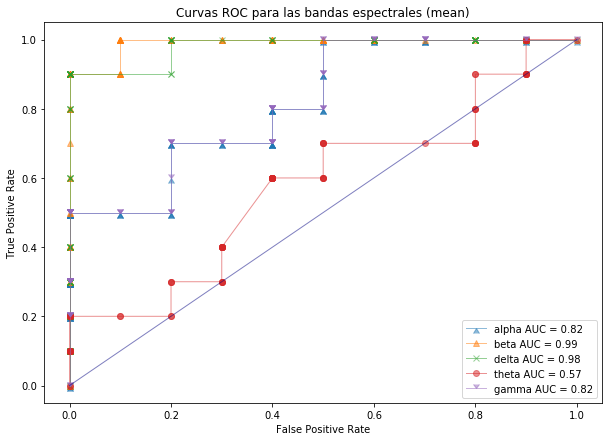

In [7]:
plt.figure(figsize=(10, 7))
plot(fprs_a, tprs_a, lw=1, marker=6, alpha=0.5, label='alpha AUC = {:.2f}'.format(aroc_a))
plot(fprs_b, tprs_b, lw=1, marker='^', alpha=0.5, label='beta AUC = {:.2f}'.format(aroc_b))
plot(fprs_d, tprs_d, lw=1, marker='x', alpha=0.5, label='delta AUC = {:.2f}'.format(aroc_d))
plot(fprs_t, tprs_t, lw=1, marker='o', alpha=0.5, label='theta AUC = {:.2f}'.format(aroc_t))
plot(fprs_g, tprs_g, lw=1, marker=7, alpha=0.5, label='gamma AUC = {:.2f}'.format(aroc_g))
plot([0, 1], [0, 1], color='navy', lw=1, linestyle='-', alpha=0.5)
xlabel('False Positive Rate')
ylabel('True Positive Rate')
legend(loc='lower right')
title('Curvas ROC para las bandas espectrales (mean)')

En una primera inspección del gráfico se observa cómo las bandas espectrales beta y delta son los mejores atributos (AUC beta = 0.99 y AUC delta = 0.98) para identificar sujetos de los grupos S y P respectivamente. Por su parte el atributo theta no resulta conveniente para la clasificación de los sujetos ya que tiene un desempeño similar al azar. Por último, tanto la banda alpha como gamma logran un desempeño similar. A continuación se presentan magnitudes que permitirán una valoración más acabada de los atributos en cuestión. 

#### Sensibilidad y especificidad para cada banda espectral (mean)

A modo de ejemplo en la siguiente tabla se ha seleccionado un umbral para cada atributo y se reporta la Especificidad (TNR) y la Sensibilidad (TPR)

In [8]:
i = 7
pd.DataFrame({
    'Sensibilidad':{
        'alpha': tprs_a[i], 
        'beta': tprs_b[i], 
        'delta': tprs_d[i], 
        'theta': tprs_t[i], 
        'gamma': tprs_g[i]
    }, 
    'Especificidad': {
        'alpha': tnrs_a[i], 
        'beta': tnrs_b[i], 
        'delta': tnrs_d[i], 
        'theta': tnrs_t[i], 
        'gamma': tnrs_g[i]
    }, 
    'Umbral': {
        'alpha': xs_a[i], 
        'beta': xs_b[i], 
        'delta': xs_d[i], 
        'theta': xs_t[i], 
        'gamma': xs_g[i]
    }
})

,Especificidad,Sensibilidad,Umbral
alpha,0.4,1.0,0.019565
beta,0.4,1.0,0.043642
delta,0.2,1.0,0.378829
gamma,0.4,1.0,0.019565
theta,0.1,0.9,0.078149


Se prosigue de igual modo para el resto de los atributos.

### Atributo: Potencia de bandas espectrales (desvío standard entre trials)

In [9]:
band_std = pd.read_pickle('pickles/band_power_std.pkl')

Se aplica la función _roc_ _univariado_ para todas las bandas espectrales:

In [10]:
xs_a, tprs_a, fprs_a, aroc_a, tnrs_a = roc_univariado(band_std['alpha'], etiquetas, 'S')
xs_b, tprs_b, fprs_b, aroc_b, tnrs_b = roc_univariado(band_std['beta'], etiquetas, 'S')
xs_d, tprs_d, fprs_d, aroc_d, tnrs_d = roc_univariado(band_std['delta'], etiquetas, 'S')
xs_t, tprs_t, fprs_t, aroc_t, tnrs_t = roc_univariado(band_std['theta'], etiquetas, 'P')
xs_g, tprs_g, fprs_g, aroc_g, tnrs_g = roc_univariado(band_std['gamma'], etiquetas, 'S')

#### Curva ROC - Atributo: banda espectral (std)

A continuación se grafican todas las curvas ROC según la clasificación anterior. Además se reporta el área bajo la curva para cada caso.

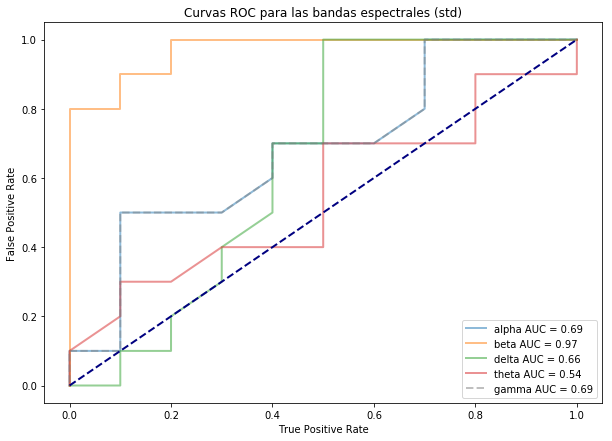

In [11]:
plt.figure(figsize=(10, 7))
plot(fprs_a, tprs_a, lw=2, alpha=0.5, label='alpha AUC = {:.2f}'.format(aroc_a))
plot(fprs_b, tprs_b, lw=2, alpha=0.5, label='beta AUC = {:.2f}'.format(aroc_b))
plot(fprs_d, tprs_d, lw=2, alpha=0.5, label='delta AUC = {:.2f}'.format(aroc_d))
plot(fprs_t, tprs_t, lw=2, alpha=0.5, label='theta AUC = {:.2f}'.format(aroc_t))
plot(fprs_g, tprs_g, lw=2, alpha=0.5, color='gray', linestyle='--', label='gamma AUC = {:.2f}'.format(aroc_g))
plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
xlabel('True Positive Rate')
ylabel('False Positive Rate')
legend(loc='lower right')
title('Curvas ROC para las bandas espectrales (std)')

Para los atributos correspondientes al desvío estándar de las potencias en cada banda espectral se encuentra que nuevamente la banda beta tiene un buen desempeño al identificar a los sujetos del grupo S con un AUC de 0.97. Para el resto de los atributos se encuentra un desempeño similar al del una clasificación por azar. Nuevamente las bandas alpha y gamma devuelven una AUC idéntica.

#### Sensibilidad y especificidad para cada banda espectral (std)

A modo de ejemplo en la siguiente tabla se ha seleccionado un umbral para cada atributo y se reporta la Especificidad (TNR) y la Sensibilidad (TPR)

In [12]:
i = 70
pd.DataFrame({'Sensibilidad':{'alpha': tprs_a[i], 'beta': tprs_b[i], 'delta': tprs_d[i], 'theta': tprs_t[i], 'gamma': tprs_g[i]}, 'Especificidad': {'alpha': tnrs_a[i], 'beta': tnrs_b[i], 'delta': tnrs_d[i], 'theta': tnrs_t[i], 'gamma': tnrs_g[i]}, 'Umbral': {'alpha': xs_a[i], 'beta': xs_b[i], 'delta': xs_d[i], 'theta': xs_t[i], 'gamma': xs_g[i]}})

,Especificidad,Sensibilidad,Umbral
alpha,0.9,0.1,0.058158
beta,1.0,0.4,0.079783
delta,0.8,0.1,0.163077
gamma,0.9,0.1,0.058158
theta,0.6,0.4,0.089524


### Atributo: Potencia de bandas espectrales normalizadas (promedio entre trials)

In [13]:
band_norm_mean = pd.read_pickle('pickles/band_power_norm_mean.pkl')

Se aplica la función _roc_ _univariado_ para todas las bandas espectrales normalizadas:

In [14]:
xs_a, tprs_a, fprs_a, aroc_a, tnrs_a = roc_univariado(band_norm_mean['alpha'], etiquetas, 'S')
xs_b, tprs_b, fprs_b, aroc_b, tnrs_b = roc_univariado(band_norm_mean['beta'], etiquetas, 'S')
xs_d, tprs_d, fprs_d, aroc_d, tnrs_d = roc_univariado(band_norm_mean['delta'], etiquetas, 'P')
xs_t, tprs_t, fprs_t, aroc_t, tnrs_t = roc_univariado(band_norm_mean['theta'], etiquetas, 'S')
xs_g, tprs_g, fprs_g, aroc_g, tnrs_g = roc_univariado(band_norm_mean['gamma'], etiquetas, 'S')

#### Curva ROC - Atributo: potencia normalizada de banda espectral (promedio entre trials)

A continuación se grafican todas las curvas ROC según la clasificación anterior. Además se reporta el área bajo la curva para cada caso.

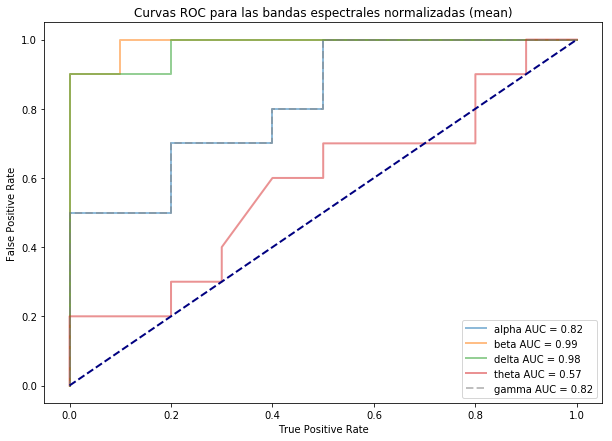

In [15]:
plt.figure(figsize=(10, 7))
plot(fprs_a, tprs_a, lw=2, alpha=0.5, label='alpha AUC = {:.2f}'.format(aroc_a))
plot(fprs_b, tprs_b, lw=2, alpha=0.5, label='beta AUC = {:.2f}'.format(aroc_b))
plot(fprs_d, tprs_d, lw=2, alpha=0.5, label='delta AUC = {:.2f}'.format(aroc_d))
plot(fprs_t, tprs_t, lw=2, alpha=0.5, label='theta AUC = {:.2f}'.format(aroc_t))
plot(fprs_g, tprs_g, lw=2, alpha=0.5, color='gray', linestyle='--', label='gamma AUC = {:.2f}'.format(aroc_g))
plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
xlabel('True Positive Rate')
ylabel('False Positive Rate')
legend(loc='lower right')
title('Curvas ROC para las bandas espectrales normalizadas (mean)')

Para el caso del promedio de las potencias de las bandas espectrales normalizadas como atributos se encuentran los mismos resultados que para el caso sin normalización.

#### Sensibilidad y especificidad para cada banda espectral normalizada (mean)

A modo de ejemplo en la siguiente tabla se ha seleccionado un umbral para cada atributo y se reporta la Especificidad (TNR) y la Sensibilidad (TPR)

In [16]:
i = 45
pd.DataFrame({'Sensibilidad':{'alpha': tprs_a[i], 'beta': tprs_b[i], 'delta': tprs_d[i], 'theta': tprs_t[i], 'gamma': tprs_g[i]}, 'Especificidad': {'alpha': tnrs_a[i], 'beta': tnrs_b[i], 'delta': tnrs_d[i], 'theta': tnrs_t[i], 'gamma': tnrs_g[i]}, 'Umbral': {'alpha': xs_a[i], 'beta': xs_b[i], 'delta': xs_d[i], 'theta': xs_t[i], 'gamma': xs_g[i]}})

,Especificidad,Sensibilidad,Umbral
alpha,0.9,0.5,0.077381
beta,0.9,0.9,0.136649
delta,1.0,0.9,0.579921
gamma,0.9,0.5,0.077381
theta,0.6,0.6,0.164523


### Atributo: Potencia de bandas espectrales normalizadas (desvío standard entre trials)

In [17]:
band_norm_std = pd.read_pickle('pickles/band_power_norm_std.pkl')

Se aplica la función _roc_ _univariado_ para todas las bandas espectrales normalizadas:

In [18]:
xs_a, tprs_a, fprs_a, aroc_a, tnrs_a = roc_univariado(band_norm_std['alpha'], etiquetas, 'S')
xs_b, tprs_b, fprs_b, aroc_b, tnrs_b = roc_univariado(band_norm_std['beta'], etiquetas, 'S')
xs_d, tprs_d, fprs_d, aroc_d, tnrs_d = roc_univariado(band_norm_std['delta'], etiquetas, 'S')
xs_t, tprs_t, fprs_t, aroc_t, tnrs_t = roc_univariado(band_norm_std['theta'], etiquetas, 'P')
xs_g, tprs_g, fprs_g, aroc_g, tnrs_g = roc_univariado(band_norm_std['gamma'], etiquetas, 'S')

#### Curva ROC - Atributo: banda espectral normalizada (std)

A continuación se grafican todas las curvas ROC según la clasificación anterior. Además se reporta el área bajo la curva para cada caso.

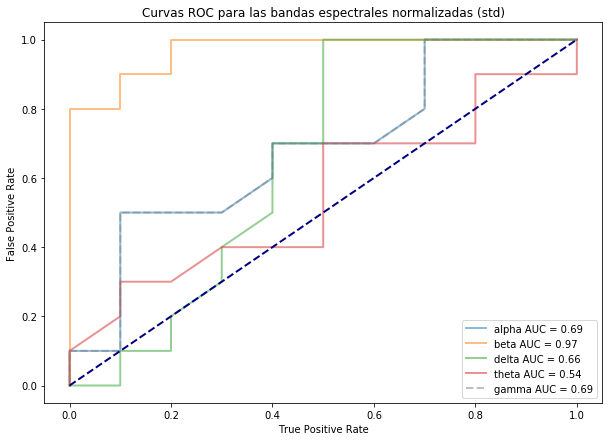

In [19]:
plt.figure(figsize=(10, 7))
plot(fprs_a, tprs_a, lw=2, alpha=0.5, label='alpha AUC = {:.2f}'.format(aroc_a))
plot(fprs_b, tprs_b, lw=2, alpha=0.5, label='beta AUC = {:.2f}'.format(aroc_b))
plot(fprs_d, tprs_d, lw=2, alpha=0.5, label='delta AUC = {:.2f}'.format(aroc_d))
plot(fprs_t, tprs_t, lw=2, alpha=0.5, label='theta AUC = {:.2f}'.format(aroc_t))
plot(fprs_g, tprs_g, lw=2, alpha=0.5, color='gray', linestyle='--', label='gamma AUC = {:.2f}'.format(aroc_g))
plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
xlabel('True Positive Rate')
ylabel('False Positive Rate')
legend(loc='lower right')
title('Curvas ROC para las bandas espectrales normalizadas (std)')

#### Sensibilidad y especificidad para cada banda espectral normalizada (mean)

A modo de ejemplo en la siguiente tabla se ha seleccionado un umbral para cada atributo y se reporta la Especificidad (TNR) y la Sensibilidad (TPR)

In [20]:
i = 70
pd.DataFrame({'Sensibilidad':{'alpha': tprs_a[i], 'beta': tprs_b[i], 'delta': tprs_d[i], 'theta': tprs_t[i], 'gamma': tprs_g[i]}, 'Especificidad': {'alpha': tnrs_a[i], 'beta': tnrs_b[i], 'delta': tnrs_d[i], 'theta': tnrs_t[i], 'gamma': tnrs_g[i]}, 'Umbral': {'alpha': xs_a[i], 'beta': xs_b[i], 'delta': xs_d[i], 'theta': xs_t[i], 'gamma': xs_g[i]}})

,Especificidad,Sensibilidad,Umbral
alpha,0.9,0.1,0.058158
beta,1.0,0.4,0.079783
delta,0.8,0.1,0.163077
gamma,0.9,0.1,0.058158
theta,0.6,0.4,0.089524


### Atributo: entropía intra-electrodo (mean y std)

In [21]:
intra_entropy = pd.read_pickle('pickles/intra_entropy.pkl')

Se aplica la función _roc_ _univariado_ para el promedio y desvio standard de entropia intra-electrodo promediado entre electrodos para cada sujeto.

In [41]:
xs_intra_mean, tprs_intra_mean, fprs_intra_mean, aroc_intra_mean, tnrs_intra_mean = roc_univariado(intra_entropy['mean'], etiquetas, 'S')
xs_intra_std, tprs_intra_std, fprs_intra_std, aroc_intra_std, tnrs_intra_std = roc_univariado(intra_entropy['std'], etiquetas, 'P')

#### Curva ROC - Atributo: entropía intra-electrodo (mean, std)

A continuación se grafican todas las curvas ROC según la clasificación anterior. Además se reporta el área bajo la curva para cada caso.

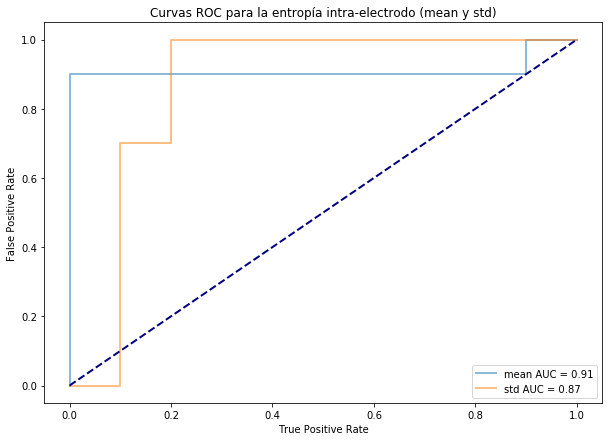

In [42]:
plt.figure(figsize=(10, 7))
plot(fprs_intra_mean, tprs_intra_mean, lw=2, alpha=0.5, label='mean AUC = {:.2f}'.format(aroc_intra_mean))
plot(fprs_intra_std, tprs_intra_std, lw=2, alpha=0.5, label='std AUC = {:.2f}'.format(aroc_intra_std))
plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
xlabel('True Positive Rate')
ylabel('False Positive Rate')
legend(loc='lower right')
title('Curvas ROC para la entropía intra-electrodo (mean y std)')

Para el caso de la entropía intra-electrodos se obtiene que el promedio de las mediciones resulta ser un buen atributo para identificar sujetos del grupo S (AUC = 0.91) mientras que su desvío estándar arroja AUC = 0.87 al identificar sujetos del grupo P. 

#### Sensibilidad y especificidad para entropía intra-electrodo (mean y std)

A modo de ejemplo en la siguiente tabla se ha seleccionado un umbral para cada atributo y se reporta la Especificidad (TNR) y la Sensibilidad (TPR)

In [43]:
i = 70
pd.DataFrame({'Sensibilidad':{'mean': tprs_intra_mean[i], 'std': tprs_intra_std[i]}, 'Especificidad': {'mean': tnrs_intra_mean[i], 'std': tnrs_intra_std[i]}, 'Umbral': {'mean': xs_intra_mean[i], 'std': xs_intra_std[i]}})

,Especificidad,Sensibilidad,Umbral
mean,1.0,0.7,1.920299
std,0.9,0.0,0.054180


### Atributo: entropía inter-electrodo (mean y std)

In [44]:
inter_entropy = pd.read_pickle('pickles/inter_entropy.pkl')

Se aplica la función _roc_ _univariado_ para el promedio y desvio standard de entropia inter-electrodo promediado entre electrodos para cada sujeto.

In [46]:
xs_inter_mean, tprs_inter_mean, fprs_inter_mean, aroc_inter_mean, tnrs_inter_mean = roc_univariado(inter_entropy['mean'], etiquetas, 'S')
xs_inter_std, tprs_inter_std, fprs_inter_std, aroc_inter_std, tnrs_inter_std = roc_univariado(inter_entropy['std'], etiquetas, 'S')

#### Curva ROC - Atributo: entropía inter-electrodo (mean, std)

A continuación se grafican todas las curvas ROC según la clasificación anterior. Además se reporta el área bajo la curva para cada caso.

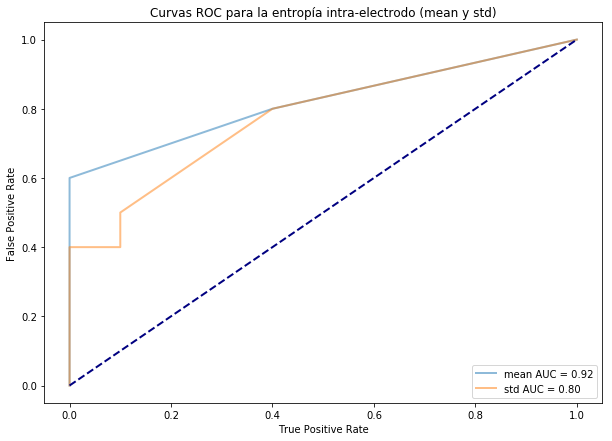

In [47]:
plt.figure(figsize=(10, 7))
plot(fprs_inter_mean, tprs_inter_mean, lw=2, alpha=0.5, label='mean AUC = {:.2f}'.format(aroc_inter_mean))
plot(fprs_inter_std, tprs_inter_std, lw=2, alpha=0.5, label='std AUC = {:.2f}'.format(aroc_inter_std))
plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
xlabel('True Positive Rate')
ylabel('False Positive Rate')
legend(loc='lower right')
title('Curvas ROC para la entropía intra-electrodo (mean y std)')

In [144]:
def plot_rocs(ax, _title, args):
    """
    Grafica las curvas roc.
    
    Args:
        args: lista de (nombre, fprs, tprs, auc)
    """
    sca(ax)
    for nombre, fprs, tprs, auc in args:
        plot(fprs, tprs, lw=2, alpha=0.5, label='{} AUC = {:.2f}'.format(nombre, auc))
        
    plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    xlabel('True Positive Rate')
    ylabel('False Positive Rate')
    legend(loc='lower right')
    title(_title)

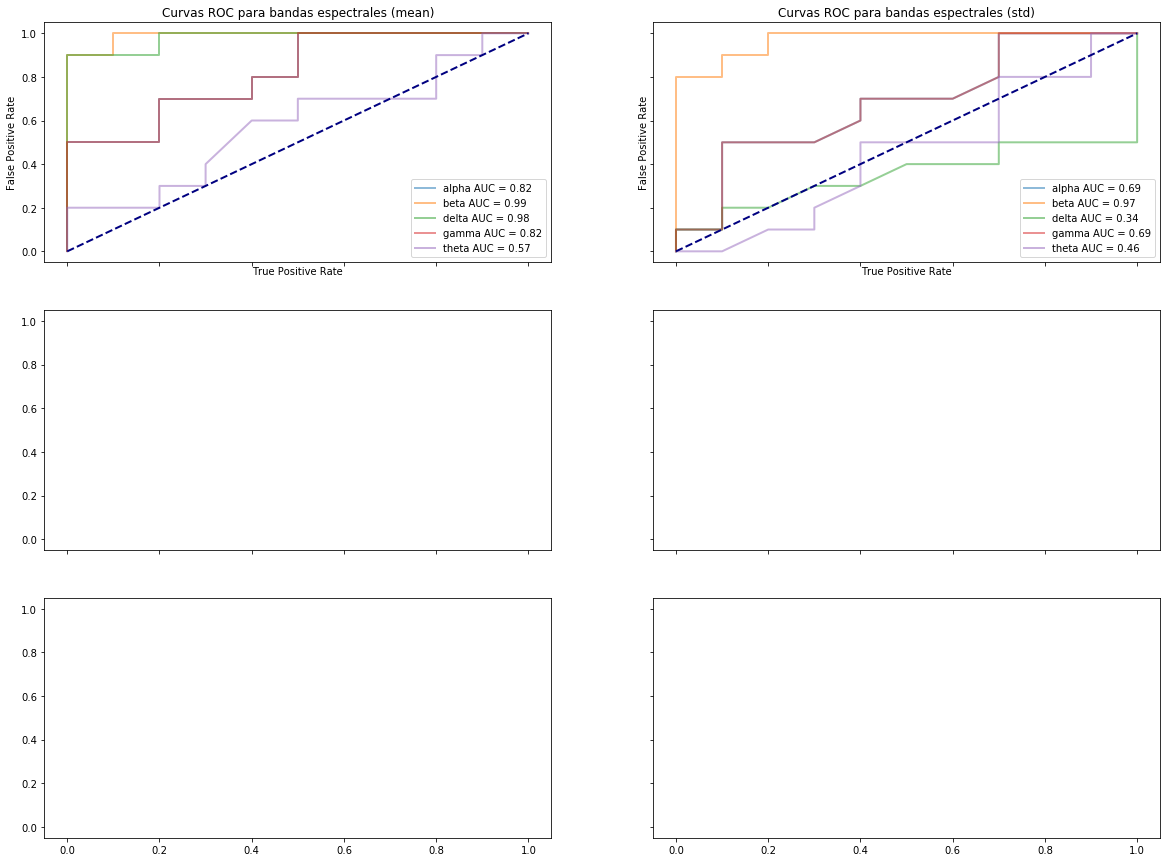

In [145]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15), sharex=True, sharey=True)
xs_a, tprs_a, fprs_a, aroc_a, tnrs_a = roc_univariado(band_norm_mean['alpha'], etiquetas, 'S')
xs_b, tprs_b, fprs_b, aroc_b, tnrs_b = roc_univariado(band_norm_mean['beta'], etiquetas, 'S')
xs_d, tprs_d, fprs_d, aroc_d, tnrs_d = roc_univariado(band_norm_mean['delta'], etiquetas, 'P')
xs_t, tprs_t, fprs_t, aroc_t, tnrs_t = roc_univariado(band_norm_mean['theta'], etiquetas, 'S')
xs_g, tprs_g, fprs_g, aroc_g, tnrs_g = roc_univariado(band_norm_mean['gamma'], etiquetas, 'S')
plot_rocs(axs[0][0], 'Curvas ROC para bandas espectrales (mean)',
         [('alpha', fprs_a, tprs_a, aroc_a),
          ('beta', fprs_b, tprs_b, aroc_b),
          ('delta', fprs_d, tprs_d, aroc_d),
          ('gamma', fprs_g, tprs_g, aroc_g),
          ('theta', fprs_t, tprs_t, aroc_t),
         ])

xs_a, tprs_a, fprs_a, aroc_a, tnrs_a = roc_univariado(band_norm_std['alpha'], etiquetas, 'S')
xs_b, tprs_b, fprs_b, aroc_b, tnrs_b = roc_univariado(band_norm_std['beta'], etiquetas, 'S')
xs_d, tprs_d, fprs_d, aroc_d, tnrs_d = roc_univariado(band_norm_std['delta'], etiquetas, 'P')
xs_t, tprs_t, fprs_t, aroc_t, tnrs_t = roc_univariado(band_norm_std['theta'], etiquetas, 'S')
xs_g, tprs_g, fprs_g, aroc_g, tnrs_g = roc_univariado(band_norm_std['gamma'], etiquetas, 'S')
plot_rocs(axs[0][1], 'Curvas ROC para bandas espectrales (std)',
         [('alpha', fprs_a, tprs_a, aroc_a),
          ('beta', fprs_b, tprs_b, aroc_b),
          ('delta', fprs_d, tprs_d, aroc_d),
          ('gamma', fprs_g, tprs_g, aroc_g),
          ('theta', fprs_t, tprs_t, aroc_t),
         ])

    TODO: Completar

## 2.1.b. Logistic Regression

In [82]:
etiquetas_binarias = [c == 'P' for c in etiquetas]

In [139]:
def plot_roc_logistic(ax, _title, args):
    """
    Calcula la regresion logística y plotea las rocs
    
    Args:
        args: lista (nombre, valores)
    """
    args_roc = []
    for nombre, values in args:
        lrc = linear_model.LogisticRegression()
        r_values = values.reshape(-1, 1)
        lrc.fit(X=r_values, y=etiquetas_binarias)
        y_score = lrc.decision_function(r_values)
        fpr, tpr, trs = metrics.roc_curve(etiquetas_binarias, y_score)
        auc = metrics.roc_auc_score(etiquetas_binarias, y_score)
        args_roc.append((nombre, fpr, tpr, auc))

    plot_rocs(ax, _title, args_roc)

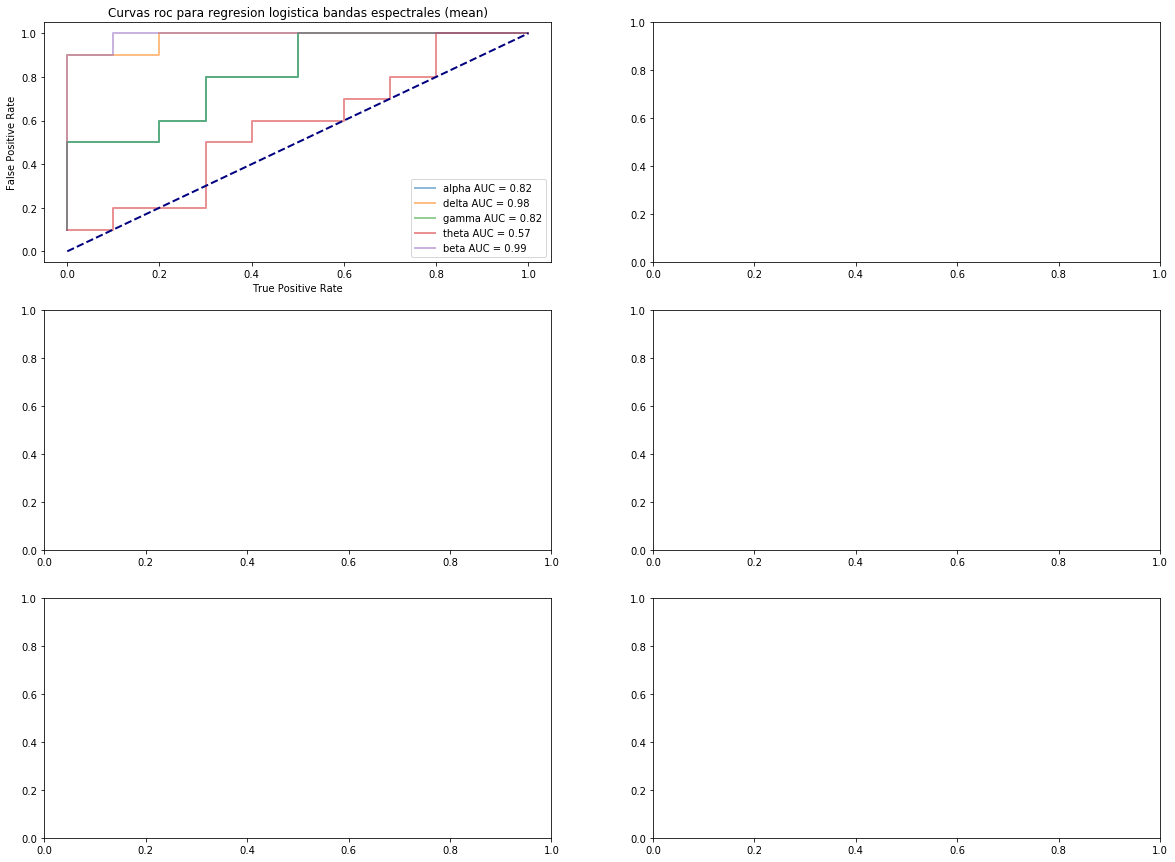

In [143]:
fig, axs = plt.subplots(3, 2, figsize=(20, 15))
plot_roc_logistic(axs[0][0], 'Curvas roc para regresion logistica bandas espectrales (mean)',
                 [('alpha', band_means['alpha'].values),
                  ('delta', band_means['delta'].values),
                  ('gamma', band_means['gamma'].values),
                  ('theta', band_means['theta'].values),
                  ('beta', band_means['beta'].values),
                 ])

In [73]:
lrc = linear_model.LogisticRegression()

In [136]:
lrc = lrc.fit(X=band_norm_mean['alpha'].values.reshape(-1, 1), y=etiquetas_binarias)

In [137]:
y_score = lrc.decision_function(band_norm_mean['alpha'].values.reshape(-1, 1))

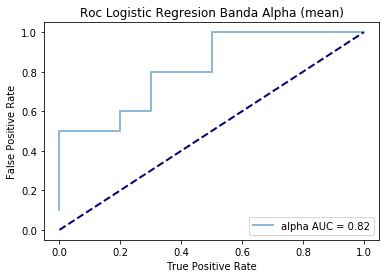

In [138]:
fpr, tpr, trs = metrics.roc_curve(etiquetas_binarias, y_score)
auc = metrics.roc_auc_score(etiquetas_binarias, y_score)
plt.figure()
plot_rocs(gca(), 'Roc Logistic Regresion Banda Alpha (mean)',
          [('alpha', fpr, tpr, auc)])

<a name="multivariado"></a>
## 2.2. Análisis Multivariado

Cargamos todos los atributos obtenidos previamente y armamos los vectores de features.

In [146]:
band_means = pd.read_pickle('pickles/band_power_mean.pkl')
band_std = pd.read_pickle('pickles/band_power_std.pkl')
band_norm_mean = pd.read_pickle('pickles/band_power_norm_mean.pkl')
band_norm_std = pd.read_pickle('pickles/band_power_norm_std.pkl')
intra_entropy = pd.read_pickle('pickles/intra_entropy.pkl')
inter_entropy = pd.read_pickle('pickles/inter_entropy.pkl')

In [151]:
features = pd.concat([band_means,band_std,band_norm_mean,band_norm_std,intra_entropy,inter_entropy], axis=1)

De esta manera, generamos una matriz de features, donde las filas son los samples o sujetos y las columnas son las features o atributos.

In [152]:
features.shape

(20, 24)

0.95


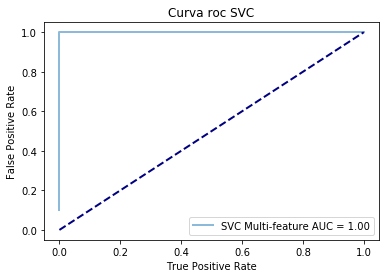

In [163]:
classifier = svm.SVC().fit(features, etiquetas_binarias)
print(classifier.score(features, etiquetas_binarias))
y_score = classifier.decision_function(features)
fpr, tpr, tps = metrics.roc_curve(etiquetas_binarias, y_score)
auc = metrics.roc_auc_score(etiquetas_binarias, y_score)

plt.figure()
plot_rocs(gca(), 'Curva roc SVC', [('SVC Multi-feature', fpr, tpr, auc)])

###  Con separación train-test

Separo en subsets de entrenamiento y testeo

    Binarizo las etiquetas o labels

In [176]:
X_train, X_test, y_train, y_test = train_test_split(features, etiquetas_binarias, test_size=0.2, random_state=0)

Entreno el clasificador usando un kernel lineal

In [177]:
classifier = svm.SVC().fit(X_train, y_train)

Evalúo el clasificador en el subset de testeo

In [183]:
classifier.score(X_test, y_test)      

0.75

In [179]:
y_score = classifier.decision_function(X_test)

In [196]:
print(y_score)
print(y_test)

[-0.10184915  0.0462039  -0.01941723 -0.0192393 ]
[False, True, False, True]


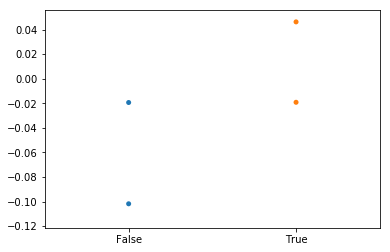

In [194]:
sns.stripplot(x=y_test, y=y_score)

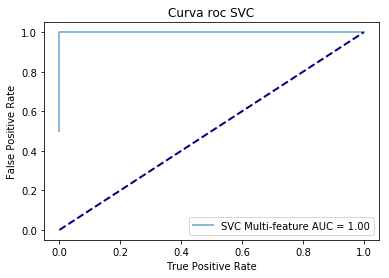

In [180]:
fpr, tpr, tps = metrics.roc_curve(y_test, y_score)
auc = metrics.roc_auc_score(y_test, y_score)

plt.figure()
plot_rocs(gca(), 'Curva roc SVC', [('SVC Multi-feature', fpr, tpr, auc)])

## 2.2.b. Pipeline

Standard Scaler.
Feature Selection utilizando solo el 10%.
SVC.

In [40]:
#sklearn.pipeline.Pipeline